## To begin, let's establish a general order of operations for this project:

### - Research good parameter values for a Tausworthe generator (non-code work)

### - Implement the generator.

In [1]:
def tausworthe(seed = 123456789101112, quantity = 100):
    assert type(seed) == int, 'Your seed must be an integer!'
    assert len(str(seed)) >= 15, 'Your seed must be at least 15 characters long!'
    
    seed = int('1' + str(seed)) # final seed is at least 16 characters long, or at least 50 bits
    print('seed: ', seed)
    # print('binary representation of your seed: ', bin(seed))
    gen_input = bin(seed)[2:]
    
    # Establish parameters for this version of the generator
    r = 2
    q = 50
    
    #Generate the specified number of psuedorandom bits
    gen_output = gen_input
    for bit in range(len(gen_input), len(gen_input) + quantity + 1):
        
        if gen_output[bit - r] == gen_output[bit - q]:
            gen_output = gen_output + '0'
        else:
            gen_output = gen_output + '1'
            
    gen_output = gen_output[51:]
    print('generated bits: ', len(gen_output))
    
    return gen_output
    

In [2]:
def create_prns(bits, L = 5):
    # Use the bits generated above to generate Uniform(0,1) PRNs.
    
    # Split the input into groups of L bits.
    num_groups = len(bits) // L
    groups = [bits[i : i + L] for i in range(num_groups)]
    
    # Convert back to decimal; divide each group by 2 ** L to get a PRN
    PRNs = [int(group, 2) / 2 ** L for group in groups]
    
    return PRNs
    

### - Code some general tests.
#### Runs for independence, Chi-sq. for goodness of fit

##### Let's start with a chi-square test for GOF. Let's use ten bins of size 0.1 each.

In [3]:
PRNs = create_prns(tausworthe(quantity = 400))
print('\n Sample PRNS: \n', PRNs[0:10])

bins = {0.1: [], 0.2: [], 0.3: [], 0.4: [], 0.5: [], 0.6: [], 0.7: [], 0.8: [], 0.9: [], 1.0: []}
for interval in bins:
    for PRN in PRNs:
        if PRN <= interval and PRN > (interval - 0.1):
            bins[interval].append(PRN)
# print('\n Results: \n', bins)


seed:  1123456789101112
generated bits:  400

 Sample PRNS: 
 [0.59375, 0.1875, 0.375, 0.75, 0.53125, 0.09375, 0.1875, 0.40625, 0.8125, 0.65625]


In [4]:
n = len(PRNs)
k = len(bins.keys())

Ei = n // k

Oi = [len(bins[bin]) for bin in bins]

chisqs = [(item - Ei) ** 2 / Ei for item in Oi]

print('Chi-sq. statistic: ', sum(chisqs))


Chi-sq. statistic:  4.125


After referencing the chi-squared table, chisq(0.05, 9) = 16.92. Our statistic is lower than that, so we fail to reject the null hypothesis that our PRNs are Uniforms.

##### Let's try a runs above / below mean test for independence!

In [5]:
runs = [0] * len(PRNs)
for i, PRN in enumerate(PRNs):
    if PRN > 0.5:
        runs[i] = '+'
    else:
        runs[i] = '-'

print('runs: ', runs)

run_count = 1

for i in range(1, len(runs)):
    if runs[i - 1] != runs[i]:
        run_count += 1

print('\nnumber of runs: ', run_count)


runs:  ['+', '-', '-', '+', '+', '-', '-', '-', '+', '+', '-', '+', '-', '+', '-', '-', '-', '-', '-', '+', '-', '-', '-', '+', '-', '-', '+', '-', '-', '-', '+', '-', '-', '+', '-', '-', '+', '+', '+', '-', '+', '-', '+', '-', '-', '-', '-', '-', '-', '+', '+', '+', '-', '-', '-', '-', '-', '-', '+', '+', '+', '-', '+', '+', '-', '+', '-', '-', '-', '-', '-', '-', '-', '+', '-', '+', '+', '+', '+', '+']

number of runs:  37


In [6]:
B = run_count
print('Number of runs: ', B)

n = len(PRNs)
n1 = len([i for i in PRNs if i > 0.5])
n2 = n - n1

print('n: ', n, '\nn1: ', n1, '\nn2: ', n2)

EB = 2 * n1 * n2 / n + 0.5
print('\nExpected number of runs: ', EB)

var_part_1 = 2 * n1 * n2
var_B = var_part_1 * (var_part_1 - n) / ((n ** 2) * (n - 1))

import math
print('\nStandard dev. of runs: ', math.sqrt(var_B))


Z = (B - EB) / (math.sqrt(var_B))

print('\nZ-statistic: ', abs(Z))

Number of runs:  37
n:  80 
n1:  32 
n2:  48

Expected number of runs:  38.9

Standard dev. of runs:  4.263712057155023

Z-statistic:  0.4456210866330829


per the tables, the relevant Z-statistic Z(0.025) is roughly 0.51. Therefore, we fail to reject the null hypothesis that these PRNs are independent.

### - Plot adjacent PRNs on a unit square! Sounds like a job for a loop.

Text(0, 0.5, 'PRN Ui+1')

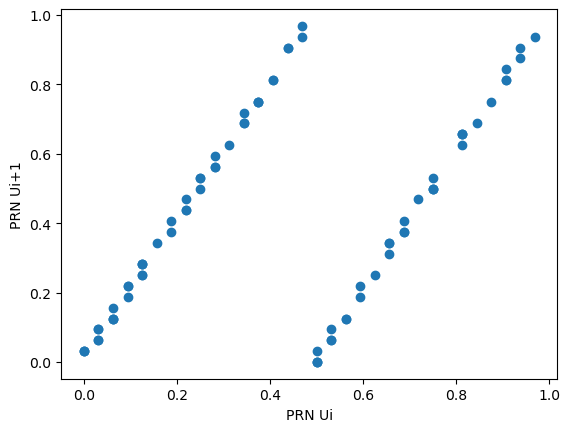

In [7]:
import matplotlib.pyplot as plt

x = [PRN for PRN in PRNs[0:n-1]]
y = [PRN for PRN in PRNs[1:]]

# print(x, '\n\n', y)
# print('\n', len(x), '\n', len(y))
# print([i - j for i, j in zip(x, y)])

plt.scatter(x, y)
plt.xlabel ('PRN Ui')
plt.ylabel ('PRN Ui+1')

The generator I've created seems to share the same 'planing' behavior we discussed in LCGs! Although I was initially alarmed upon seeing this result, I'm reassured by the fact that the generator passed our statistical tests. Maybe there are ways to tinker with the parameters to increase the number of planes?

### - Generate a few Nor(0, 1) RVs using the Tausworthe Uniforms.
#### Inverse Transform, or something else?
There is no closed-form inverse CDF for the standard normal distribution. We can, however, use a workaround discussed in class: look the value up in the Z-table!

'inverse transformed' standard normals:
 [0.23720210932878769, -0.887146559018876, -0.31863936396437514, 0.6744897501960817, 0.0784124127331122, -1.318010897303537, -0.887146559018876, -0.23720210932878769, 0.887146559018876, 0.40225006532172536]

sample size:  77


(array([ 8.,  8.,  6., 10.,  9., 13., 11.,  5.,  4.,  3.]),
 array([-1.86273187, -1.49018549, -1.11763912, -0.74509275, -0.37254637,
         0.        ,  0.37254637,  0.74509275,  1.11763912,  1.49018549,
         1.86273187]),
 <BarContainer object of 10 artists>)

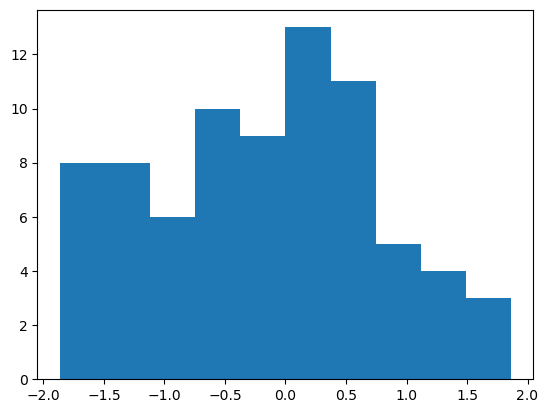

In [23]:
import scipy.stats as st

norms = [st.norm.ppf(PRN) for PRN in PRNs if PRN != 0.0]
print("'inverse transformed' standard normals:\n", norms[0:10])
print('\nsample size: ', len(norms))

plt.hist(norms)

This is a somewhat questionable Normal(0, 1) histogram, but you get the idea! This could be due to the sample size.